In [1]:
# !pip --version

In [2]:
# !pip install tensorflow[and-cuda]

In [3]:
#3.11.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

2023-10-16 02:59:47.293307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 02:59:47.293438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 02:59:47.293490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 02:59:47.308681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# get gpu
tf.config.list_physical_devices('GPU')

2023-10-16 02:59:51.574175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 02:59:51.579309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 02:59:51.579368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data = pd.read_csv('./cancerDataset/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [6]:
labels = data['label']
data = data.drop(['label'], axis=1)

In [7]:
# data.head()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (8012, 2352)
y_train shape:  (8012,)


In [9]:
import random
from imblearn.over_sampling import RandomOverSampler 

x_train=np.array(x_train).reshape(-1,28,28,3)

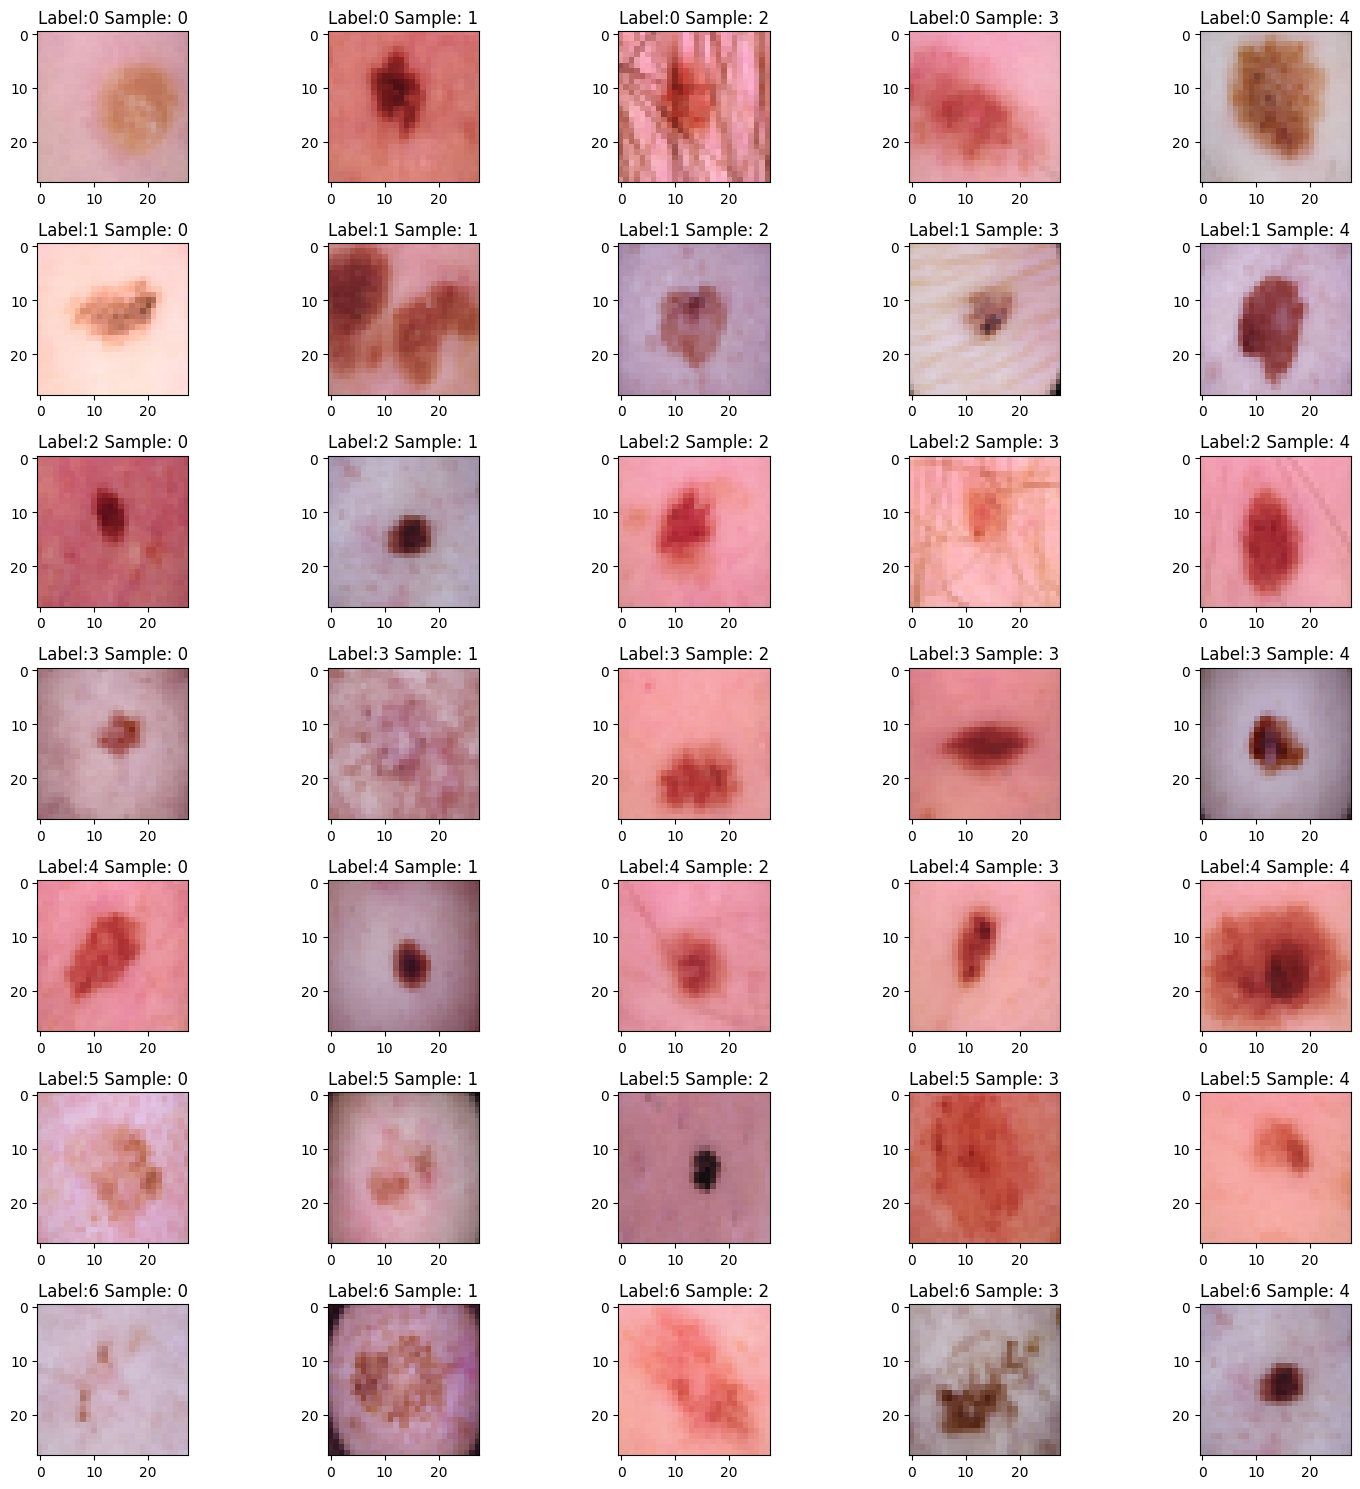

In [10]:
#show training 5 samples for each class
fig, ax = plt.subplots(7,5)
fig.set_size_inches(15,15)
for i in range(7):
    for j in range (5):
        randomIndex = random.randint(0, len(x_train))
        ax[i,j].imshow(x_train[randomIndex])
        ax[i,j].set_title("Label:" + str(i) + " Sample: " + str(j))
        # ax[i,j].set_title(y_train[randomIndex])
plt.tight_layout()


In [11]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout

# CNN
model = keras.Sequential()
model.add(Conv2D(32, kernel_size = (2,2), input_shape = (28, 28, 3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (5,5), activation = 'relu')) # bigger kernel
model.add(Conv2D(32, kernel_size = (1,1), activation = 'relu')) # reduce depth
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization()) # normalize

model.add(Flatten())

# NN
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7,activation='softmax'))

model.summary()


2023-10-16 03:00:01.315579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 03:00:01.315672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 03:00:01.315702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 03:00:02.199789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 03:00:02.199930: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                   

In [12]:
# from tensorflow.keras.callbacks import EarlyStopping

with tf.device('/GPU:0'):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #0.001
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

status = model.fit(x_train, y_train,validation_split=0.3, epochs=50, batch_size=128,shuffle=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #0.001
# model.compile(optimizer=optimizer,
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

# status = model.fit(x_train, y_train,validation_split=0.3, epochs=50, batch_size=128,shuffle=True,user_multiprocessing=True)

Epoch 1/50


2023-10-16 03:00:29.307792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-16 03:00:32.437657: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd14b8a2700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 03:00:32.437732: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-16 03:00:32.451351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 03:00:32.574777: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 [==============================] - 12s 42ms/step - loss: 1.8560 - accuracy: 0.3374 - val_loss: 1.7397 - val_accuracy: 0.4721
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 1.1578 - accuracy: 0.6097 - val_loss: 1.3172 - val_accuracy: 0.6381
Epoch 3/50
44/44 [==============================] - 1s 17ms/step - loss: 1.0083 - accuracy: 0.6614 - val_loss: 1.1150 - val_accuracy: 0.6635
Epoch 4/50
44/44 [==============================] - 1s 18ms/step - loss: 0.9476 - accuracy: 0.6787 - val_loss: 0.9828 - val_accuracy: 0.6834
Epoch 5/50
44/44 [==============================] - 1s 19ms/step - loss: 0.8887 - accuracy: 0.6940 - val_loss: 1.0301 - val_accuracy: 0.6618
Epoch 6/50
44/44 [==============================] - 1s 17ms/step - loss: 0.8517 - accuracy: 0.7035 - val_loss: 0.8602 - val_accuracy: 0.7047
Epoch 7/50
44/44 [==============================] - 1s 18ms/step - loss: 0.8181 - accuracy: 0.7126 - val_loss: 0.8585 - val_accuracy: 0.6980
Epoch 8/50
44/44 [=====

In [14]:
model.save('task1.keras')

In [15]:
x_test=np.array(x_test).reshape(-1,28,28,3)

In [16]:
x_test.shape

(2003, 28, 28, 3)

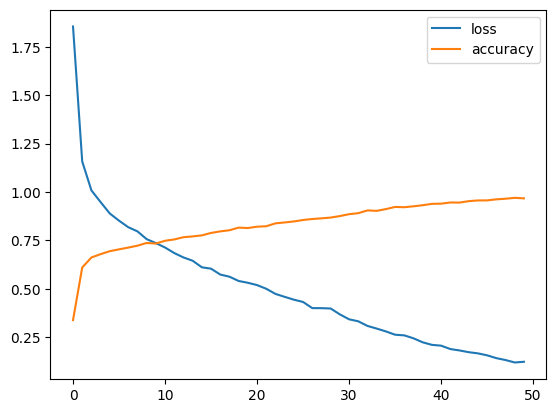

In [17]:
plt.plot(status.history['loss'])
plt.plot(status.history['accuracy'])
plt.legend(['loss','accuracy'])


In [18]:
with tf.device('/GPU:0'):
    status = model.evaluate(x_test, y_test,use_multiprocessing=True)

63/63 [==============================] - 1s 7ms/step - loss: 1.0330 - accuracy: 0.7324


In [19]:
# predict classes
def predict_classes(model, x_test):
    y_pred = model.predict(x_test)
    classes = np.argmax(y_pred, axis = 1)
    return classes

In [20]:
# plot test error
print("Test Loss:", status[0]) 
print("Test Accuracy:", status[1])


Test Loss: 1.0329986810684204
Test Accuracy: 0.7324013710021973


In [21]:
def calculateAccuracy(comfusionMatrix):
    accuracy = 0
    for i in range(len(comfusionMatrix)):
        accuracy += comfusionMatrix[i][i]
    return accuracy/np.sum(comfusionMatrix)

def calculatePrecicion(comfusionMatrix):
    precision = 0
    for i in range(len(comfusionMatrix)):
        precision += comfusionMatrix[i][i]/np.sum(comfusionMatrix[:,i])
    return precision/len(comfusionMatrix)

def calculateRecall(comfusionMatrix):
    recall = 0
    for i in range(len(comfusionMatrix)):
        recall += comfusionMatrix[i][i]/np.sum(comfusionMatrix[i,:])
    return recall/len(comfusionMatrix)

# revise these functions

63/63 [==============================] - 1s 8ms/step
Accuracy:  0.7324013979031453
Precision:  0.5546350801103404
Recall:  0.3776540440605922
              precision    recall  f1-score   support

           0       0.62      0.14      0.24        69
           1       0.64      0.31      0.42        93
           2       0.46      0.34      0.39       228
           3       0.42      0.18      0.25        28
           4       0.79      0.95      0.86      1338
           5       0.47      0.43      0.45        21
           6       0.47      0.29      0.36       226

    accuracy                           0.73      2003
   macro avg       0.55      0.38      0.42      2003
weighted avg       0.70      0.73      0.70      2003



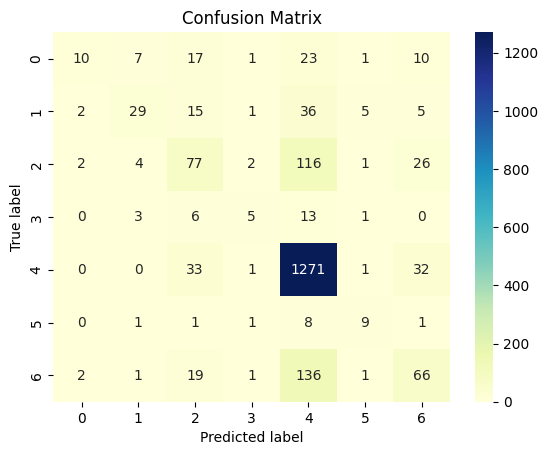

In [24]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = predict_classes(model, x_test)
confusionMatrixData = confusion_matrix(y_test, y_pred)
# heat map of confusion matrix with x and y axis labels
fig = sns.heatmap(confusionMatrixData, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(7), yticklabels=range(7))
fig.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')

print("Accuracy: ", calculateAccuracy(confusionMatrixData))
print("Precision: ", calculatePrecicion(confusionMatrixData))
print("Recall: ", calculateRecall(confusionMatrixData))

print(metrics.classification_report(y_test, y_pred))